In [1]:
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import os, copy, random
import matplotlib.pyplot as plt
import collections
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

#Reference : https://github.com/zalandoresearch/fashion-mnist utils/mnist_reader.
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Sandal


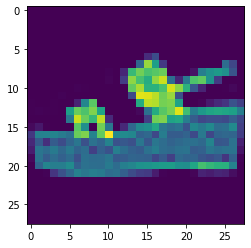

In [2]:
classes=('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
X_train, y_train = load_mnist('./dataset/fashion_mnist/', kind='train')
X_test, y_test = load_mnist('./dataset/fashion_mnist/', kind='t10k')
# visualize and check data and label.
index = 12
plt.imshow(X_train[index].reshape(28,28))
print(classes[y_train[index]])

In [3]:
# count number of each class -> check data balance.
train_count = collections.Counter(y_train)
print(train_count)
test_count = collections.Counter(y_test)
print(test_count)

Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})
Counter({9: 1000, 2: 1000, 1: 1000, 6: 1000, 4: 1000, 5: 1000, 7: 1000, 3: 1000, 8: 1000, 0: 1000})


In [4]:
#make this reproducible with seed fixed
np.random.seed(42)

#subsampling each class
subset_X_train = []
subset_y_train = []
subset_per_each_train = 600
for i in range(len(classes)):
    _class_idx = np.where(y_train == i)[0]
    print('sampled from class {} : {}'.format(i, len(_class_idx)))
    np.random.shuffle(_class_idx)
    subset_X_train.extend(X_train[_class_idx[:subset_per_each_train]])
    subset_y_train.extend(y_train[_class_idx[:subset_per_each_train]])

subset_X_test = []
subset_y_test = []
subset_per_each_test = 100
for i in range(len(classes)):
    _class_idx = np.where(y_test == i)[0]
    print('sampled from class {} : {}'.format(i, len(_class_idx)))
    np.random.shuffle(_class_idx)
    subset_X_test.extend(X_test[_class_idx[:subset_per_each_test]])
    subset_y_test.extend(y_test[_class_idx[:subset_per_each_test]])

print(len(subset_X_train), len(subset_y_train))
print(len(subset_X_test), len(subset_y_test))

scaler = StandardScaler()
subset_X_train = scaler.fit_transform(np.array(subset_X_train))
subset_y_train = np.array(subset_y_train)
subset_X_test = scaler.fit_transform(np.array(subset_X_test))
subset_y_test = np.array(subset_y_test)


sampled from class 0 : 6000
sampled from class 1 : 6000
sampled from class 2 : 6000
sampled from class 3 : 6000
sampled from class 4 : 6000
sampled from class 5 : 6000
sampled from class 6 : 6000
sampled from class 7 : 6000
sampled from class 8 : 6000
sampled from class 9 : 6000
sampled from class 0 : 1000
sampled from class 1 : 1000
sampled from class 2 : 1000
sampled from class 3 : 1000
sampled from class 4 : 1000
sampled from class 5 : 1000
sampled from class 6 : 1000
sampled from class 7 : 1000
sampled from class 8 : 1000
sampled from class 9 : 1000
6000 6000
1000 1000


In [5]:
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(subset_X_train, subset_y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

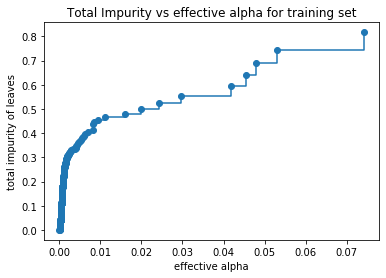

In [6]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [11]:
print(len(ccp_alphas))
ccp_alpha_round = [np.around(num, 4) for num in ccp_alphas]
print(ccp_alphas[:10])
print(ccp_alpha_round[:10])

ccp_alpha_list=[]
[ccp_alpha_list.append(x) for x in ccp_alpha_round if x not in ccp_alpha_list]
print(len(ccp_alpha_list))

511
[0.         0.00016289 0.00016304 0.00016374 0.00016429 0.0001645
 0.00016505 0.00016546 0.00016563 0.00016583]
[0.0, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002]
53


In [30]:
clfs = []
for ccp_alpha in ccp_alpha_list:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha, max_features="sqrt", criterion="entropy", max_depth=12)
    clf.fit(subset_X_train, subset_y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 15 with ccp_alpha: 0.0529


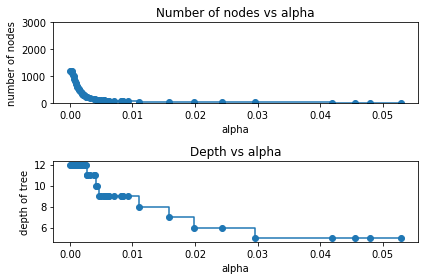

In [31]:
clfs = clfs[:-1]
ccp_alphas = ccp_alpha_list[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_ylim([0, 3000])
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

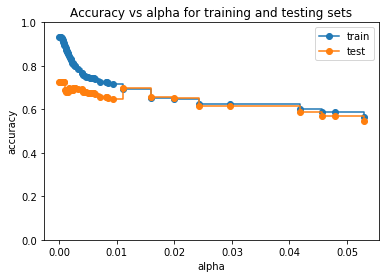

In [32]:
train_scores = [clf.score(subset_X_train, subset_y_train) for clf in clfs]
test_scores = [clf.score(subset_X_test, subset_y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_ylim(0.0, 1.0)
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [34]:
for a, n, d in zip(ccp_alphas, node_counts,depth):
    if (a>= 0.001 and a <=0.003):
        print('pruned number of nodes and depth', a, n, d)
    if (a==0):
        print('original number of nodes and depth', a, n, d)
        
print(ccp_alphas[-1])

original number of nodes and depth 0.0 1189 12
pruned number of nodes and depth 0.001 705 12
pruned number of nodes and depth 0.0011 643 12
pruned number of nodes and depth 0.0012 591 12
pruned number of nodes and depth 0.0013 559 12
pruned number of nodes and depth 0.0014 513 12
pruned number of nodes and depth 0.0015 491 12
pruned number of nodes and depth 0.0016 461 12
pruned number of nodes and depth 0.0017 417 12
pruned number of nodes and depth 0.0019 365 12
pruned number of nodes and depth 0.002 349 12
pruned number of nodes and depth 0.0021 321 12
pruned number of nodes and depth 0.0022 291 12
pruned number of nodes and depth 0.0023 287 12
pruned number of nodes and depth 0.0024 267 12
pruned number of nodes and depth 0.0026 245 12
pruned number of nodes and depth 0.0027 233 11
pruned number of nodes and depth 0.0028 229 11
0.0529


In [20]:
parameters = {'criterion':['entropy'], 'max_features':['sqrt'], 'max_depth':[4, 6, 8, 10, 12], 'ccp_alpha':[0.002, 0.004, 0.006, 0.008, 0.010]}
clf = DecisionTreeClassifier(random_state=42)
clf_GS = GridSearchCV(clf, parameters, verbose=2, cv=10, n_jobs=-1)
clf_GS.fit(subset_X_train, subset_y_train)


Fitting 10 folds for each of 25 candidates, totalling 250 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.002, 0.004, 0.006, 0.008, 0.01],
                         'criterion': ['entropy'],
                         'max_depth': [4, 6, 8, 10, 12],
                         'max_features': ['sqrt']},
             verbose=2)

In [21]:
print(clf_GS.best_params_)

{'ccp_alpha': 0.002, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt'}


In [38]:
print(clf_GS.best_estimator_.tree_.node_count)
print(clf_GS.best_estimator_.tree_.max_depth)

285
10


In [22]:
subset_y_test_pred = clf_GS.best_estimator_.predict(subset_X_test)
test_acc = metrics.accuracy_score(subset_y_test, subset_y_test_pred)
print('Test Accuracy of best model: {}'.format(test_acc))

Test Accuracy of best model: 0.737


In [52]:
#for learning rate analysis change subset_per_each_train as 100, 200, 300, 400, 500, 600

#make this reproducible with seed fixed
np.random.seed(42)

#subsampling each class
subset_X_train = []
subset_y_train = []
subset_per_each_train = 600
for i in range(len(classes)):
    _class_idx = np.where(y_train == i)[0]
    print('sampled from class {} : {}'.format(i, len(_class_idx)))
    np.random.shuffle(_class_idx)
    subset_X_train.extend(X_train[_class_idx[:subset_per_each_train]])
    subset_y_train.extend(y_train[_class_idx[:subset_per_each_train]])

print(len(subset_X_train), len(subset_y_train))
print(len(subset_X_test), len(subset_y_test))

scaler = StandardScaler()
subset_X_train = scaler.fit_transform(np.array(subset_X_train))
subset_y_train = np.array(subset_y_train)

sampled from class 0 : 6000
sampled from class 1 : 6000
sampled from class 2 : 6000
sampled from class 3 : 6000
sampled from class 4 : 6000
sampled from class 5 : 6000
sampled from class 6 : 6000
sampled from class 7 : 6000
sampled from class 8 : 6000
sampled from class 9 : 6000
6000 6000
1000 1000


In [53]:
l_clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='sqrt', ccp_alpha=0.002, random_state=42)
l_clf.fit(subset_X_train, subset_y_train)
subset_y_test_pred = l_clf.predict(subset_X_test)
train_score = l_clf.score(subset_X_train, subset_y_train)
test_acc = metrics.accuracy_score(subset_y_test, subset_y_test_pred)
print('Train score {:.4f} Test Accuracy of best model: {}'.format(train_score, test_acc))

Train score 0.6217 Test Accuracy of best model: 0.595


In [ ]:
train_score_list=[]
test_acc_list=[]
for a in np.arange(0.01, 0.06, 0.01):
    l_clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='sqrt', ccp_alpha=a, random_state=42)
    l_clf.fit(subset_X_train, subset_y_train)
    subset_y_test_pred = l_clf.predict(subset_X_test)
    train_score = l_clf.score(subset_X_train, subset_y_train)
    test_acc = metrics.accuracy_score(subset_y_test, subset_y_test_pred)
    train_score_list.append(train_score)
    test_acc_list.append(test_acc)
print(train_score_list)
print(test_acc_list)

[0.6216666666666667, 0.619, 0.6158333333333333, 0.6158333333333333, 0.6003333333333334, 0.6003333333333334, 0.5305, 0.5305, 0.5305, 0.49066666666666664, 0.4175, 0.38533333333333336, 0.38533333333333336, 0.38533333333333336, 0.38533333333333336, 0.314, 0.314, 0.28583333333333333, 0.28583333333333333, 0.28583333333333333]
[0.595, 0.594, 0.597, 0.597, 0.587, 0.587, 0.521, 0.521, 0.521, 0.48, 0.404, 0.374, 0.374, 0.374, 0.374, 0.303, 0.303, 0.282, 0.282, 0.282]


In [6]:
#performance
import time
t1 = time.time()
l_clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='sqrt', ccp_alpha=0.002, random_state=42)
l_clf.fit(subset_X_train, subset_y_train)
end_t1 = time.time()
train_score = l_clf.score(subset_X_train, subset_y_train)
t2 = time.time()
subset_y_test_pred = l_clf.predict(subset_X_test)
#test_acc = metrics.accuracy_score(subset_y_test, subset_y_test_pred)
end_t2 = time.time()
print('Train time {:.4f} Test time {:.4f}'.format((end_t1 - t1), (end_t2 - t2)))

Train time 0.1682 Test time 0.0039
